In [ ]:
# when executed in a Google Colab setting, we must install the required libraries

# !pip install torch
# !pip install os
# !pip install transformers
# !pip install numpy
# !pip install pandas

In [17]:
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions.beta import Beta
import numpy as np
import pandas as pd
import random
import pickle
import base64
import matplotlib.pyplot as plt
import re
from sklearn.metrics import f1_score

In [18]:
DATASET_FILEPATH = './drive/MyDrive/Thesis/'
DATASET_SEED = 2
MODEL_SIZE = 3
SEED = 42
torch.manual_seed(SEED)
LOAD_WEIGHTS_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/average/model_without_head.pth')
SAVE_WEIGHTS_PATH = os.path.join(DATASET_FILEPATH, '/weights-and-graphs/average-bert-frozen/model.pth')

EMB_SIZE = 'base' # 'base' 768 embeddings or 'large' 1024 embeddings

In [ ]:
train_csv_file = os.path.join(DATASET_FILEPATH, f'{EMB_SIZE}/{DATASET_SEED}/processed/train_dataset.csv')
validation_csv_file = os.path.join(DATASET_FILEPATH, f'{EMB_SIZE}/{DATASET_SEED}/processed/validation_dataset.csv')

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print('Device: ', device)

Device:  cpu


In [20]:
def to_tensor(base64_str):
    return pickle.loads(base64.b64decode(base64_str.encode()))

selected_columns = ['audio_file_name', 'classification', 'hubert_embeddings', 'bert_embeddings']

train_df = pd.read_csv(train_csv_file, usecols=selected_columns, converters={'hubert_embeddings': to_tensor, 'bert_embeddings': to_tensor})
validation_df = pd.read_csv(validation_csv_file, usecols=selected_columns, converters={'hubert_embeddings': to_tensor, 'bert_embeddings': to_tensor})

In [21]:
def process_training_set(train_df, oversample_minority=False, undersample_majority=False):
  """
  Re-sample the training dataset, with options to oversample minority class and undersample majority class based on audio lengths.

  :param train_df: DataFrame containing the training data with columns ['classification', 'audio_file_name'] among others.
  :param oversample_minority: Boolean, if True, the minority class (classification == 0) is duplicated to balance the dataset.
  :param undersample_majority: Boolean, if True, majority class data with audio lengths above a threshold (specified by DROP_SEGMENTS) are dropped.
  :returns: DataFrame with the desired processed training data.
  """
  if oversample_minority:
    class_0 = train_df[train_df['classification'] == 0]
    train_df = pd.concat([train_df, class_0])
  if undersample_majority:
    DROP_SEGMENTS = 5
    def get_audio_length_group(file_name):
        return int(re.findall(r'\d+', file_name)[-1])
    train_df['audio_length_group'] = train_df['audio_file_name'].apply(get_audio_length_group)
    train_df = train_df[train_df['audio_length_group'] <= DROP_SEGMENTS]
    train_df = train_df.drop(columns=['audio_length_group'])

  # some indices are duplicated / removed so we have to reset them
  train_df.reset_index(drop=True, inplace=True)
  return train_df

def print_dataset_balance(df):
    """
    Prints the balance of classifications in a given dataset.

    :param df: DataFrame containing the data with a 'classification' column.
    """
    classification_counts = df['classification'].value_counts().reset_index()
    classification_counts.columns = ['classification', 'count']
    total_rows = classification_counts['count'].sum()
    classification_counts['percentage'] = (classification_counts['count'] / total_rows) * 100
    classification_counts['percentage'] = classification_counts['percentage'].round(1)
    print(classification_counts)

In [22]:
train_df = process_training_set(train_df, oversample_minority=True, undersample_majority=True)
print_dataset_balance(train_df)

# Apply means across hubert embeddings
train_df['hubert_embeddings'] = train_df['hubert_embeddings'].apply(lambda x: torch.mean(x, dim=0))
validation_df['hubert_embeddings'] = validation_df['hubert_embeddings'].apply(lambda x: torch.mean(x, dim=0))

   classification  count  percentage
0               0    606        62.0
1               1    372        38.0


In [23]:
class EmbeddingsDataset(Dataset):
    def __init__(self, bert_embeddings, hubert_embeddings, labels):
        self.bert_embeddings = bert_embeddings
        self.hubert_embeddings = hubert_embeddings
        self.labels = labels

    def __len__(self):
        return len(self.bert_embeddings)

    def __getitem__(self, idx):
        bert_embedding = self.bert_embeddings[idx]
        hubert_embedding = self.hubert_embeddings[idx]
        label = self.labels[idx]
        return bert_embedding, hubert_embedding, label

bert_train_data, bert_valid_data = validation_df['bert_embeddings'], validation_df['bert_embeddings']
hubert_train_data, hubert_valid_data = train_df['hubert_embeddings'], validation_df['hubert_embeddings']
train_labels, valid_labels = train_df['classification'], validation_df['classification']

train_dataset = EmbeddingsDataset(bert_train_data, hubert_train_data, train_labels)
valid_dataset = EmbeddingsDataset(bert_valid_data, hubert_valid_data, valid_labels)

def collate_fn(batch):
    augmented_batch = []
    lambda_dist = Beta(torch.tensor([1.0]), torch.tensor([1.0]))  # Beta distribution parameters

    for bert_emb, hubert_emb, label in batch:
        bert_emb_rand, hubert_emb_rand, label_rand = random.choice(batch)
        lambda_sample = lambda_dist.sample().item()

        bert_emb_aug = lambda_sample * bert_emb + (1 - lambda_sample) * bert_emb_rand
        hubert_emb_aug = lambda_sample * hubert_emb + (1 - lambda_sample) * hubert_emb_rand
        label_aug = lambda_sample * label + (1 - lambda_sample) * label_rand
        augmented_batch.append((bert_emb_aug, hubert_emb_aug, label_aug))

    batch.extend(augmented_batch)

    bert_embeddings, hubert_embeddings, labels = zip(*batch)
    bert_embeddings = torch.stack(bert_embeddings)
    hubert_embeddings = torch.stack(hubert_embeddings)
    labels = torch.Tensor(labels)

    return bert_embeddings, hubert_embeddings, labels

In [24]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

In [25]:
if MODEL_SIZE == 1:
  hidden_layers = [256]
  dropout_rate = 0.1
elif MODEL_SIZE == 2:
  hidden_layers = [512,256]
  dropout_rate = 0.2
elif MODEL_SIZE == 3:
  hidden_layers = [768, 512, 256]
  dropout_rate = 0.3
elif MODEL_SIZE == 4:
  hidden_layers = [1024, 768, 512, 256]
  dropout_rate = 0.4

In [26]:
class AudioModel(nn.Module):
    def __init__(self, audio_embedding_dim=768, hidden_layers=[], dropout_rate=0.5):
        super(AudioModel, self).__init__()

        layers = []
        prev_dim = audio_embedding_dim
        for dim in hidden_layers:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = dim

        self.model = nn.Sequential(*layers)

    def forward(self, audio_embedding):
        return self.model(audio_embedding)

In [27]:
class CustomModel(nn.Module):
  def __init__(self, bert_embedding_dim=768, hubert_embedding_dim=768 if EMB_SIZE == 'base' else 1024, hidden_dim1=256, hidden_dim2=256, bert_hidden_dim=16, output_dim=1, dropout_rate=0.4):
      super(CustomModel, self).__init__()
      self.bert_layer1 = nn.Linear(bert_embedding_dim, bert_hidden_dim)
      self.dropout1 = nn.Dropout(dropout_rate)
      self.bert_layer2 = nn.Linear(bert_hidden_dim, bert_hidden_dim)
      self.dropout2 = nn.Dropout(dropout_rate)

      self.audio_model = AudioModel(audio_embedding_dim=hubert_embedding_dim, hidden_layers=hidden_layers, dropout_rate=0)


      self.fc1 = nn.Linear(hidden_layers[-1] + bert_hidden_dim, hidden_dim1)
      self.dropout5 = nn.Dropout(dropout_rate)
      self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
      self.dropout6 = nn.Dropout(dropout_rate)
      self.output_layer = nn.Linear(hidden_dim2, output_dim)

  def forward(self, bert_embedding, hubert_embedding):
      bert_out = F.relu(self.bert_layer1(bert_embedding))
      bert_out = self.dropout1(bert_out)
      bert_out = F.relu(self.bert_layer2(bert_out))
      bert_out = self.dropout2(bert_out)

      # Use the audio_model to process hubert_embedding
      hubert_out = self.audio_model(hubert_embedding)

      concatenated = torch.cat((bert_out, hubert_out), dim=1)

      fc_out = F.relu(self.fc1(concatenated))
      fc_out = self.dropout5(fc_out)
      fc_out = F.relu(self.fc2(fc_out))
      fc_out = self.dropout6(fc_out)

      output = self.output_layer(fc_out)
      return output

In [28]:
model = CustomModel()

audio_model_weights = torch.load(LOAD_WEIGHTS_PATH)
model.audio_model.load_state_dict(audio_model_weights)

# Freeze the weights for the audio model
for param in model.audio_model.parameters():
    param.requires_grad = False

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [29]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for bert_embeddings, hubert_embeddings, labels in iterator:
            predictions = model(bert_embeddings, hubert_embeddings).squeeze(1)
            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)
            binary_predictions = (torch.sigmoid(predictions) > 0.5).int() # new

            all_predictions.extend(binary_predictions.cpu().numpy()) # new
            all_labels.extend(labels.cpu().numpy()) # new

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        macro_f1 = f1_score(all_labels, all_predictions, average='macro') # new

    return epoch_loss / len(iterator), epoch_acc / len(iterator), macro_f1 # new part: macro_f1

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for bert_embeddings, hubert_embeddings, labels in iterator:
        optimizer.zero_grad()
        predictions = model(bert_embeddings, hubert_embeddings).squeeze(1)
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Epoch: 01
	Train Loss: 0.283 | Train Acc: 89.24%
	 Val. Loss: 0.753 |  Val. Acc: 79.86%
Epoch: 02
	Train Loss: 0.107 | Train Acc: 95.83%
	 Val. Loss: 0.975 |  Val. Acc: 83.33%
Epoch: 03
	Train Loss: 0.089 | Train Acc: 96.18%
	 Val. Loss: 1.369 |  Val. Acc: 82.64%
Epoch: 04
	Train Loss: 0.083 | Train Acc: 96.53%
	 Val. Loss: 1.362 |  Val. Acc: 82.99%
Epoch: 05
	Train Loss: 0.085 | Train Acc: 97.57%
	 Val. Loss: 1.442 |  Val. Acc: 83.33%
Epoch: 06
	Train Loss: 0.073 | Train Acc: 97.22%
	 Val. Loss: 1.656 |  Val. Acc: 82.99%
Epoch: 07
	Train Loss: 0.083 | Train Acc: 95.83%
	 Val. Loss: 1.660 |  Val. Acc: 82.99%
Epoch: 08
	Train Loss: 0.071 | Train Acc: 97.22%
	 Val. Loss: 1.806 |  Val. Acc: 82.64%
Epoch: 09
	Train Loss: 0.085 | Train Acc: 96.88%
	 Val. Loss: 1.842 |  Val. Acc: 82.99%
Epoch: 10
	Train Loss: 0.083 | Train Acc: 96.88%
	 Val. Loss: 2.047 |  Val. Acc: 82.29%
Model weights saved


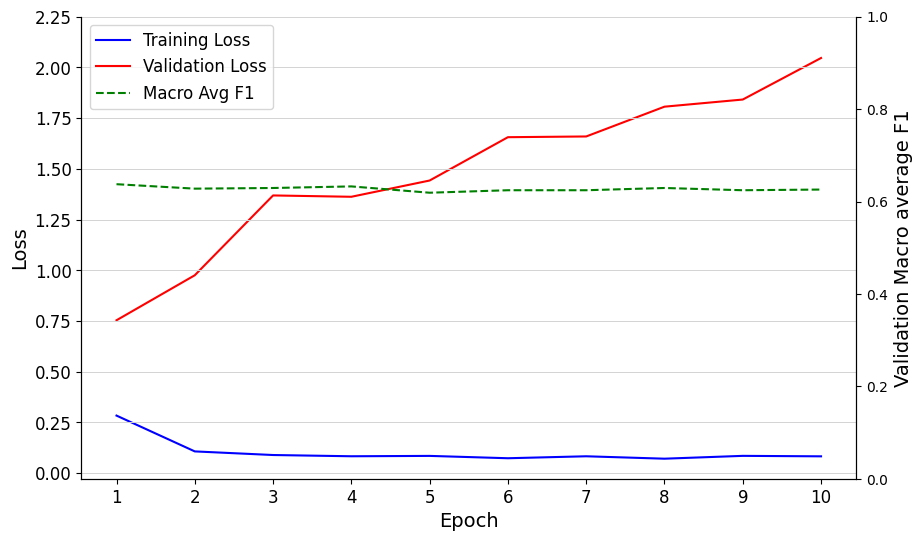

In [30]:
N_EPOCHS = 10

train_losses = []
valid_losses = []
macro_f1_scores = [] # new
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, epoch_macro_f1 = evaluate(model, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    macro_f1_scores.append(epoch_macro_f1) # new

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

torch.save(model.state_dict(), SAVE_WEIGHTS_PATH)
print('Model weights saved')

plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS+1), train_losses, color='blue', label='Training Loss')
plt.plot(range(1, N_EPOCHS+1), valid_losses, color='red', label='Validation Loss')

plt.xticks(range(1, N_EPOCHS+1))
max_loss = max(max(train_losses), max(valid_losses))
max_val = round(max_loss + 0.5, 1)
LARGE_TICK_SPACING = True
if not LARGE_TICK_SPACING:
  yticks = [i for i in np.arange(0, max_val, 0.5)]
else:
  yticks = [i for i in np.arange(0, max_val, 0.25)]
plt.yticks(yticks)

for y in yticks:
    plt.axhline(y, color='lightgrey', linewidth=0.7)

ax = plt.gca()
ax.spines['right'].set_color('black')  # Set the color of the right spine to green
ax.spines['top'].set_visible(False)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# New: to make second vertical axis visible
ax2 = ax.twinx()
ax2.plot(range(1, N_EPOCHS+1), macro_f1_scores, color='green', label='Macro Avg F1', linestyle='--')
ax2.set_ylabel('Validation Macro average F1', fontsize=14)
ax2.set_ylim(0, 1)  # since F1 score range is [0, 1]
ax2.tick_params(axis='y', labelcolor='black')
ax2.spines['top'].set_visible(False)

# Create a combined legend for the plots
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)
